# Generate seurat object


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
from scipy import sparse



sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

In [2]:
epithelials = ['preCiliated',
'SOX9_basalis',
'SOX9_functionalis_I',
'SOX9_functionalis_II',
'SOX9_luminal',
'SOX9_basalis',
'Ciliated',
'preGlandular',
'preLuminal',
'Glandular',
'Luminal',
'Glandular_secretory',
'Glandular_secretory_FGF7']

mesenchymal = ['ePV_2',
'eStromal',
'eStromal_MMPs',
'ePV_1a',
'ePV_1b',
'Fibroblast_basalis',
'dStromal_early',
'dStromal_mid',
'dStromal_late'
]

immune = ['uNK1', 'uNK3', 'eM1', 'eM2']

In [3]:
celltypes_of_interest = immune # sum([immune, mesenchymal, epithelials], [])

## Load raw counts for sample of interest

In [4]:
adata = sc.read('/nfs/team292/lg18/endometriosis/integrated_objects/cells_integrated.h5ad')
adata.X.shape

(390867, 17736)

In [5]:
annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium.csv',index_col=0)
annot_df.head()
annot_all = annot_df['Mareckova_celltype'].to_dict()
annot = dict(annot_all)
adata.obs['Mareckova_celltype'] = adata.obs_names.map(annot)

annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_epithelial_CLEAN.csv',index_col=0)
annot_df.at[annot_df['Mareckova_epi_celltype'] == 'Hormones', 'Mareckova_epi_celltype'] = 'eHormones'
annot_df.at[annot_df['Mareckova_epi_celltype'] == 'Hormones_secretory', 'Mareckova_epi_celltype'] = 'eHormones'
annot_df.head()
annot1 = annot_df['Mareckova_epi_celltype'].to_dict()
annot.update(annot1)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_mesenchymal_CLEAN.csv',index_col=0)
annot_df.at[annot_df['Mareckova_mesen_celltype'] == 'Hormones', 'Mareckova_mesen_celltype'] = 'sHormones'
annot_df.head()
annot2 = annot_df['Mareckova_mesen_celltype'].to_dict()
annot.update(annot2)

annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_endothelial.csv',index_col=0)
annot_df.head()
annot2 = annot_df['Mareckova_endo_celltype'].to_dict()
annot.update(annot2)

annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_immune.csv',index_col=0)
annot_df.head()
annot2 = annot_df['immune_subcluster_labels'].to_dict()
annot.update(annot2)


adata.obs['celltype'] = adata.obs_names.map(annot)
print(adata.obs['celltype'].value_counts())

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,39,40,41,42,46,47,55,56,58,59,60,62,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (15,19,21,22,23,24,25,39,40,41,46,47,60,61,63,64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (13,15,17,18,19,21,22,23,24,25,41,42,46,55,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


eStromal           55612
dStromal_mid       43790
Mesen_dStromal     22381
dStromal_early     16804
Venous             15494
                   ...  
cDC1                 188
dHormones            172
Plasma_B_Cell         89
Red_Blood_Cell        43
Epi_cervix_KRT5       23
Name: celltype, Length: 74, dtype: int64


### Subset to clusters of interest

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Mareckova_celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


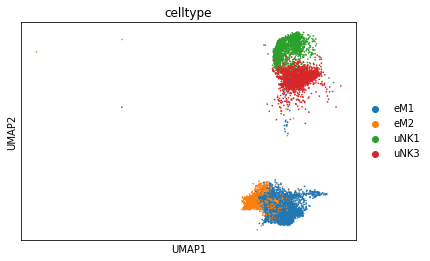

In [6]:
set(adata.obs['Mareckova_celltype'])
adata = adata[[ i in celltypes_of_interest for i in adata.obs['celltype'] ]]
sc.pl.umap(adata, color=['celltype'])

### Exclude cycling cells

In [7]:
adata = adata[[ i in ["G1"] for i in adata.obs.phase ]]

## Exclude patients under hormones

In [8]:
adata = adata[[ i not in ["Hormones", "PeriMenopause_Hormones"] for i in adata.obs['Binary Stage'] ]]
print(adata.obs['Binary Stage'].value_counts())

Proliferative    3375
Secretory        2874
Menstrual          30
Name: Binary Stage, dtype: int64


### Define disease column

In [9]:
adata.obs['disease'] = 'Endo'
adata.obs.at[adata.obs['Group'] == 'Ctrl_whole_uterus', 'disease'] = 'Ctrl'
adata.obs.at[adata.obs['Group'] == 'Ctrl_Superficial', 'disease'] = 'Ctrl'
print(adata.obs['disease'].value_counts())

Trying to set attribute `.obs` of view, copying.


Ctrl    3219
Endo    3060
Name: disease, dtype: int64


# Move to Seurat

In [10]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [11]:
import anndata
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
# This is just to allow moving adata to R without errors
adata.X = adata.X.toarray()

idx = ['n_genes', 'sample',  'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 
       'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet']
for i in idx:
    del adata.obs[i]
    
adata.obs['celltype'] = adata.obs['celltype'].astype(str)

del adata.obsm['X_scVI']
del adata.obsm['X_umap']
del adata.obsp['connectivities']
del adata.obsp['distances']
del adata.uns

In [13]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 14635 6085 
metadata(0):
assays(1): X
rownames(14635): A1BG A2M ... ZYX ZZEF1
rowData names(220): gene_ids.0.Fonseca feature_types.0.Fonseca ...
  highly_variable_nbatches n_cells
colnames(6085): HCA_A_RepT_RNA13247830_ACGAGGATCTTTCCTC-Mareckova
  HCA_A_RepT_RNA13247830_ACTGTCCGTTAAGAAC-Mareckova ...
  GSM5572240_TTTACGTCAGCGCGTT-Lai GSM5572240_TTTGATCAGTGTAGAT-Lai
colData names(58): library StudyName ... celltype disease
reducedDimNames(0):
altExpNames(0):


In [14]:
%%R

library(Seurat)
seurat_andata = as.Seurat(adata, counts = "X", data = "X")
rm(adata)
Idents(seurat_andata) = seurat_andata$celltype

saveRDS(seurat_andata, "/nfs/team292/lg18/endometriosis/SeuratR_objects/cells_immune.rds")
rm(seurat_andata)
